# Echo state networks

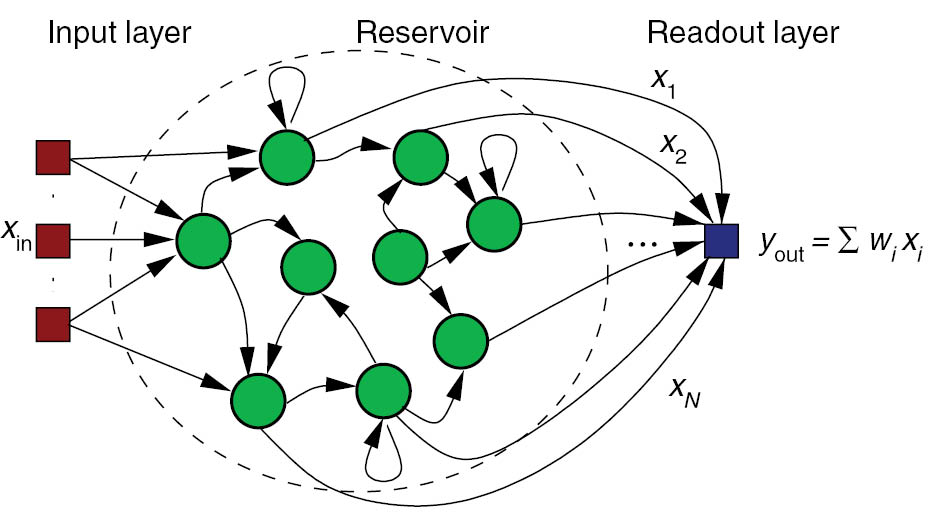

In [1]:
from ANNarchy import *
clear()
setup(dt=1.0)

ANNarchy 4.6 (4.6.9.1) on linux (posix). 


Each neuron in the reservoir follows the following equations:

$$
    \tau \frac{dx(t)}{dt} + x(t) = \sum_\text{input} W^\text{IN} \, r^\text{IN}(t) + g \,  \sum_\text{rec} W^\text{REC} \, r(t) + \xi(t)
$$

$$
    r(t) = \tanh(x(t))
$$

where $\xi(t)$ is some uniform noise.

In [2]:
ESN_Neuron = Neuron(
    parameters = """
        tau = 30.0 : population
        g = 1.0 : population
        noise = 0.01
    """,
    equations="""
        tau * dx/dt + x = sum(in) + g * sum(exc) + noise * Uniform(-1, 1)

        r = tanh(x)
    """
)

We take one input neuron and a RC of 400 units.

In [3]:
# Input population
inp = Population(1, Neuron(parameters="r=0.0"))

# Recurrent population
N = 400
pop = Population(N, ESN_Neuron)

In [4]:
pop.tau = 30.0
pop.g = 1.4
pop.noise = 0.01

Input weights are classically uniformly distributed between -1 and 1.

Recurrent weights are sampled from the normal distribution with mean 0 and variance $g^2 / N$. Here, we put the synaptic scaling $g$ inside the neuron.

In [5]:
# Input weights
Wi = Projection(inp, pop, 'in')
Wi.connect_all_to_all(weights=Uniform(-1.0, 1.0))

# Recurrent weights
Wrec = Projection(pop, pop, 'exc')
Wrec.connect_all_to_all(weights=Normal(0., 1/np.sqrt(N)))

In [6]:
compile()

Compiling... 
OK 


In [7]:
m = Monitor(pop, 'r')

A single trial lasts 3s, with a step input between 100 and 200 ms.

In [8]:
def trial():
    "Runs two trials for a given spectral radius."

    # Reset firing rates
    inp.r = 0.0
    pop.x = 0.0
    pop.r = 0.0
    
    # Run the trial
    simulate(100.)
    inp[0].r = 1.0
    simulate(100.0) # initial stimulation
    inp[0].r = 0.0
    simulate(2800.)
    
    data = m.get('r')
    
    return data

We run two trials successively to look at the chaoticity depending on $g$. 

In [9]:
pop.g = 1.4
data1 = trial()
data2 = trial()

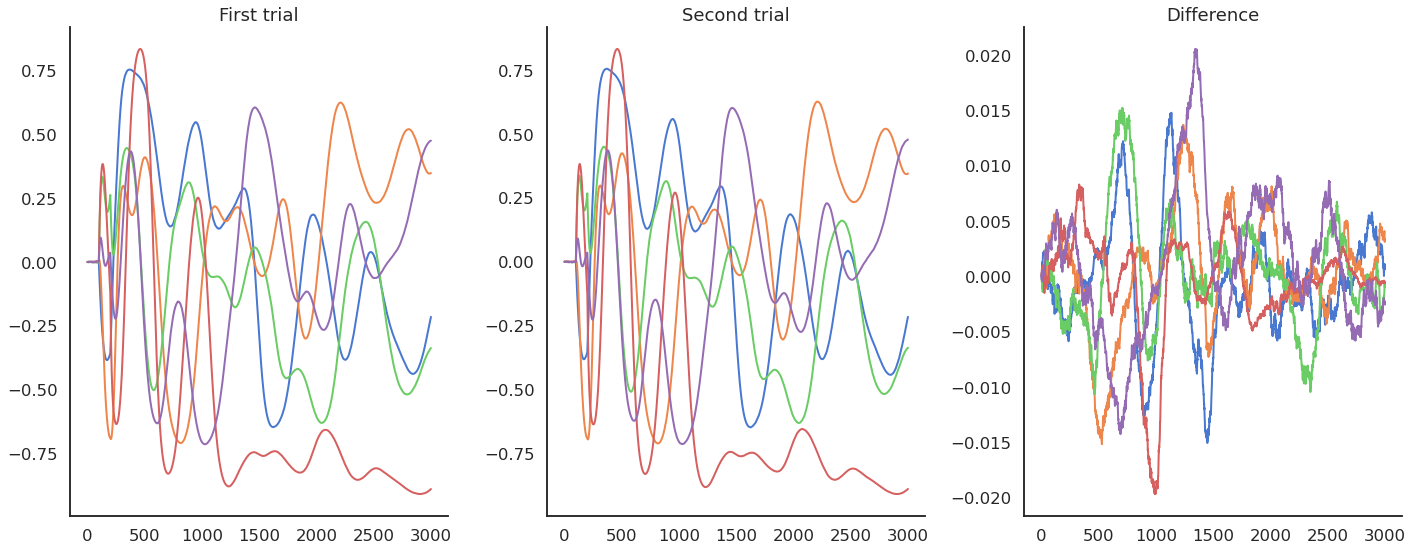

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("talk")

plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.title("First trial")
for i in range(5):
    plt.plot(data1[:, i], lw=2)
plt.subplot(132)
plt.title("Second trial")
for i in range(5):
    plt.plot(data2[:, i], lw=2)
plt.subplot(133)
plt.title("Difference")
for i in range(5):
    plt.plot(data1[:, i] - data2[:, i], lw=2)

sns.despine()
plt.tight_layout()
plt.show()

We can now train the readout neurons to reproduce a step signal after 2 seconds.

For simplicity, we just train a L1-regularized linear regression (LASSO) on the reservoir activity.

In [11]:
target = np.zeros(3000)
target[2000:2500] = 1.0

In [12]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.001, max_iter=10000)
reg.fit(data1, target)
pred = reg.predict(data2)

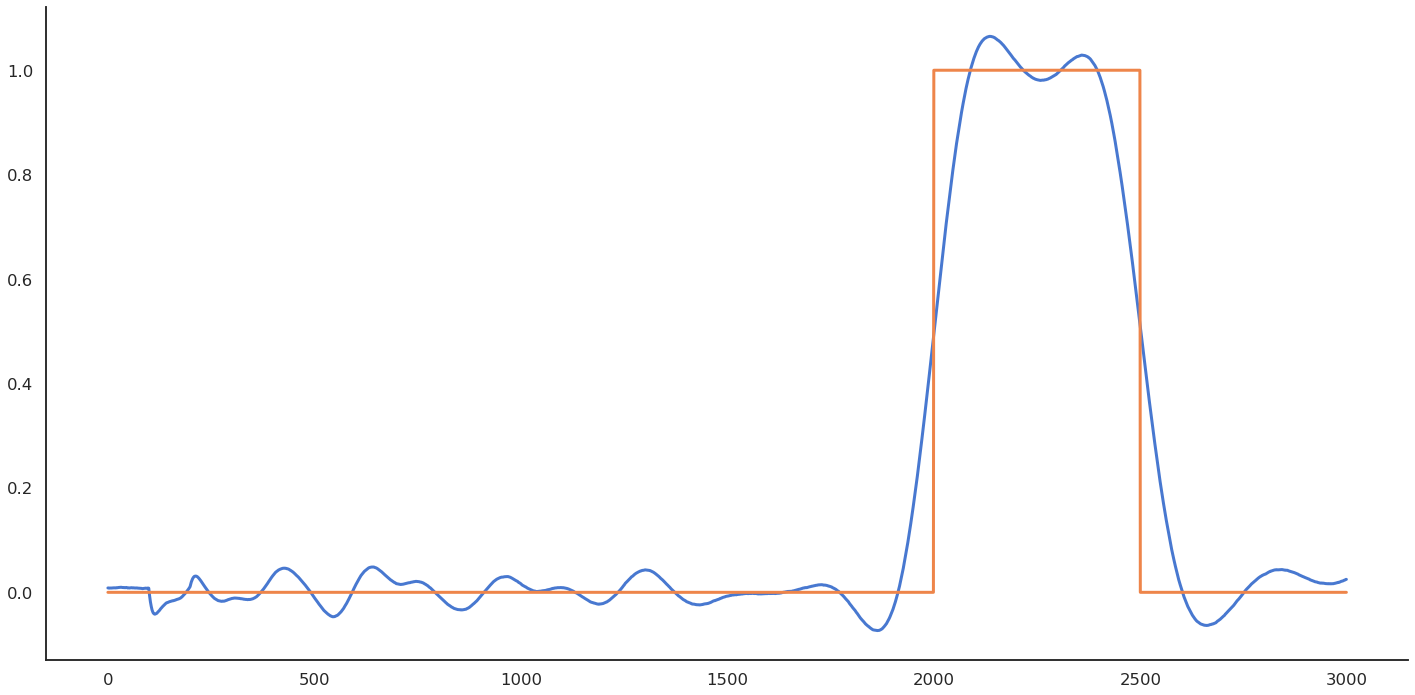

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(pred, lw=3)
plt.plot(target, lw=3)

sns.despine()
plt.tight_layout()
plt.show()